In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

# Les librairies pour le Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from scipy.sparse import hstack

from sklearn.ensemble import RandomForestClassifier # Ou RandomForestClassifier si tu prédis une classe
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, r2_score, fbeta_score # Ou accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


In [3]:
# 1. Chargement du dataset propre
# On spécifie l'encoding pour être sûr de bien lire les caractères spéciaux
df = pd.read_csv('steam_dataset_clean.csv', encoding='utf-8-sig')

# 2. Sécurité pour le TF-IDF
# Même si on a nettoyé, le format CSV peut parfois lire des vides comme des NaN.
# On force la colonne description à être du texte vide si elle est manquante.
if 'short_description' in df.columns:
    df['short_description'] = df['short_description'].fillna('')

# 3. Vérification rapide
print(f"Dimensions du dataset : {df.shape}")
print("-" * 30)
print(df.info())
print("-" * 30)
# Affiche les 5 premières lignes pour vérifier que tout est en ordre
df.head()

Dimensions du dataset : (82074, 83)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82074 entries, 0 to 82073
Data columns (total 83 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   name                                    82074 non-null  object 
 1   appid                                   82074 non-null  int64  
 2   required_age                            82074 non-null  int64  
 3   is_free                                 82074 non-null  int64  
 4   controller_support                      82074 non-null  int64  
 5   short_description                       82074 non-null  object 
 6   initialprice                            82074 non-null  float64
 7   is_hit                                  82074 non-null  int64  
 8   windows                                 82074 non-null  int64  
 9   mac                                     82074 non-null  int6

,name,appid,required_age,is_free,controller_support,short_description,initialprice,is_hit,windows,mac,...,Lang_English,Lang_French,Lang_German,Lang_Spanish,Lang_Portuguese,Lang_Russian,Lang_Japanese,Lang_Korean,Lang_Simplified Chinese,Lang_Polish
0,Counter-Strike,10,0,0,0,Play the world's number 1 online action game. ...,9.99,1,1,1,...,1,1,1,1,0,0,0,1,1,0
1,Team Fortress Classic,20,0,0,0,One of the most popular online action games of...,4.99,1,1,1,...,1,1,1,1,0,1,0,1,1,0
2,Day of Defeat,30,0,0,0,Enlist in an intense brand of Axis vs. Allied ...,4.99,1,1,1,...,1,1,1,1,0,0,0,0,0,0
3,Deathmatch Classic,40,0,0,0,Enjoy fast-paced multiplayer gaming with Death...,4.99,1,1,1,...,1,1,1,1,0,1,0,1,1,0
4,Half-Life: Opposing Force,50,0,0,0,Return to the Black Mesa Research Facility as ...,4.99,1,1,1,...,1,1,1,0,0,0,0,1,0,0


In [4]:
ids = df['appid']   #appid will be ignored for training
y = df['is_hit']
X = df.drop(columns=['is_hit', 'appid'])


# First split : we isolate the test set
X_temp, X_test, y_temp, y_test, ids_temp, ids_test = train_test_split(
    X, y, ids,
    test_size=0.15,  # 15% for testset
    random_state=42,
    stratify=y
)

# Seconde split : we split validation and train sets
X_train, X_val, y_train, y_val, ids_train, ids_val = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.1765,  # ~17.65% of remaining = 15% of total
    random_state=42,
    stratify=y_temp
)

print(f"Train : {len(X_train)} ({len(X_train)/len(df):.1%})") # Devrait être ~70%
print(f"Val   : {len(X_val)} ({len(X_val)/len(df):.1%})")     # Devrait être ~15%
print(f"Test  : {len(X_test)} ({len(X_test)/len(df):.1%})")   # Devrait être ~15%

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_val", X_val.shape)
print("y_val", y_val.shape)
print("\nX_test", X_test.shape)
print("y_test", y_test.shape)


print("\nNumber of hits in train", len(y_train[ y_train == 1 ]))
print("Number of non-hits in train", len(y_train[ y_train == 0 ]))
print("\nNumber of hits in val", len(y_val[ y_val == 1 ]))
print("Number of non-hits in val", len(y_val[ y_val == 0 ]))
print("\nNumber of hits in test", len(y_test[ y_test == 1 ]))
print("Number of non-hits in test", len(y_test[ y_test == 0 ]))

Train : 57449 (70.0%)
Val   : 12313 (15.0%)
Test  : 12312 (15.0%)
X_train (57449, 81)
y_train (57449,)
X_val (12313, 81)
y_val (12313,)

X_test (12312, 81)
y_test (12312,)

Number of hits in train 11386
Number of non-hits in train 46063

Number of hits in val 2440
Number of non-hits in val 9873

Number of hits in test 2440
Number of non-hits in test 9872


In [5]:
# On définit un transformateur qui applique TF-IDF sur chaque colonne spécifiée
preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', TfidfVectorizer(max_features=750, stop_words='english'), 'name'),
        ('short_desc_tfidf', TfidfVectorizer(max_features=2000, stop_words='english'), 'short_description')
    ],
    remainder='drop' # 'drop' ignore les autres colonnes pour l'instant, 'passthrough' les garde
)

# Fit on Train
X_train_tfidf = preprocessor.fit_transform(X_train)

# Transform on Val
X_val_tfidf   = preprocessor.transform(X_val)    # Transform uniquement

# Transform on Test
X_test_tfidf = preprocessor.transform(X_test)

In [6]:
print(X_train.columns)
print(X_train.dtypes.to_string())

Index(['name', 'required_age', 'is_free', 'controller_support',
       'short_description', 'initialprice', 'windows', 'mac', 'linux',
       'genre_Accounting', 'genre_Action', 'genre_Adventure',
       'genre_Animation & Modeling', 'genre_Audio Production', 'genre_Casual',
       'genre_Design & Illustration', 'genre_Early Access', 'genre_Education',
       'genre_Free to Play', 'genre_Game Development', 'genre_Gore',
       'genre_Indie', 'genre_Massively Multiplayer', 'genre_Movie',
       'genre_Nudity', 'genre_Photo Editing', 'genre_RPG', 'genre_Racing',
       'genre_Sexual Content', 'genre_Short', 'genre_Simulation',
       'genre_Software', 'genre_Software Training', 'genre_Sports',
       'genre_Strategy', 'genre_Utilities', 'genre_Video Production',
       'genre_Violent', 'genre_Web Publishing', 'categorie_Captions/Subtitles',
       'categorie_Co-op', 'categorie_Cross-Platform Multiplayer',
       'categorie_Family Sharing', 'categorie_Full Controller Support',
       'cat

In [7]:
# 1. Préparez vos features "classiques" (Numériques / Catégorielles encodées)
# Assurez-vous d'avoir enlevé les colonnes de texte brut (name, description)
# et l'ID (appid) s'il traîne encore.
cols_to_drop = ['name', 'short_description', 'appid'] # Adaptez selon vos colonnes
X_train_numeric = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val_numeric   = X_val.drop(columns=cols_to_drop, errors='ignore')
X_test_numeric = X_test.drop(columns=cols_to_drop, errors='ignore')

# 2. La Fusion (hstack)
# On colle les chiffres à gauche et le TF-IDF à droite
X_train_final = hstack([X_train_numeric, X_train_tfidf])
X_val_final   = hstack([X_val_numeric, X_val_tfidf])
X_test_final = hstack([X_test_numeric, X_test_tfidf])

# 3. Vérification
print(f"Features numériques : {X_train_numeric.shape}") # ex: (65659, 5)
print(f"Features TF-IDF   : {X_train_tfidf.shape}")   # ex: (65659, 5000)
print(f"Total combiné     : {X_train_final.shape}")   # ex: (65659, 5005)

Features numériques : (57449, 79)
Features TF-IDF   : (57449, 2750)
Total combiné     : (57449, 2829)


In [8]:
# Configuration pour la Classification
# n_estimators=100 : 100 arbres
# class_weight='balanced' : TRÈS IMPORTANT si tu as peu de "Succès" (hits) par rapport aux jeux normaux.
# Cela force le modèle à faire attention à la classe minoritaire.
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, class_weight={0: 1, 1: 5}) # We punish more harshly errors on is_hit=1

print("Entraînement du Classifier en cours...")
rf_model.fit(X_train_final, y_train)

# Prediction
y_probs = rf_model.predict_proba(X_test_final)[:, 1]

Entraînement du Classifier en cours...


In [9]:
# Test on different proba thresholds
for seuil in [0.2, 0.3, 0.4, 0.5]:
    preds = (y_probs >= seuil).astype(int)
    recall = classification_report(y_test, preds, output_dict=True)['1']['recall']
    precision = classification_report(y_test, preds, output_dict=True)['1']['precision']
    f2score = fbeta_score(y_test, preds, beta=2)
    print(f"Seuil {seuil} -> Recall: {recall:.2f} | Precision: {precision:.2f} | F2-Score: {f2score:.2f}")

Seuil 0.2 -> Recall: 0.76 | Precision: 0.37 | F2-Score: 0.63
Seuil 0.3 -> Recall: 0.60 | Precision: 0.46 | F2-Score: 0.57
Seuil 0.4 -> Recall: 0.44 | Precision: 0.54 | F2-Score: 0.46
Seuil 0.5 -> Recall: 0.30 | Precision: 0.61 | F2-Score: 0.33


In [10]:
# Test on different proba thresholds
y_probs_val = rf_model.predict_proba(X_val_final)[:, 1]

for seuil in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
    preds = (y_probs_val >= seuil).astype(int)
    recall = classification_report(y_val, preds, output_dict=True)['1']['recall']
    precision = classification_report(y_val, preds, output_dict=True)['1']['precision']
    f2score = fbeta_score(y_val, preds, beta=2)
    print(f"Seuil {seuil} -> Recall: {recall:.2f} | Precision: {precision:.2f} | F2-Score: {f2score:.2f}")

Seuil 0.05 -> Recall: 0.99 | Precision: 0.22 | F2-Score: 0.58
Seuil 0.1 -> Recall: 0.93 | Precision: 0.27 | F2-Score: 0.62
Seuil 0.2 -> Recall: 0.77 | Precision: 0.38 | F2-Score: 0.63
Seuil 0.3 -> Recall: 0.61 | Precision: 0.47 | F2-Score: 0.57
Seuil 0.4 -> Recall: 0.45 | Precision: 0.54 | F2-Score: 0.47
Seuil 0.5 -> Recall: 0.30 | Precision: 0.60 | F2-Score: 0.33
Seuil 0.7 -> Recall: 0.07 | Precision: 0.78 | F2-Score: 0.08
Seuil 0.9 -> Recall: 0.01 | Precision: 0.96 | F2-Score: 0.01


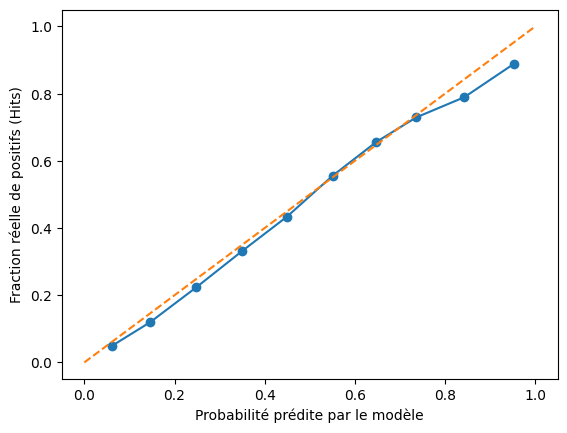

In [11]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Votre Modèle')
plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
plt.xlabel('Probabilité prédite par le modèle')
plt.ylabel('Fraction réelle de positifs (Hits)')
plt.show()

In [12]:
# --- 6. Calibration & Optimisation du Seuil (Sur VALIDATION) ---

# A. Calibration (Correction de l'overconfidence)
# On utilise 'prefit' car le modèle est déjà entraîné sur X_train
calibrated_clf = CalibratedClassifierCV(rf_model, method='isotonic', cv='prefit')
calibrated_clf.fit(X_val_final, y_val) # On calibre sur la Validation

val_probs = calibrated_clf.predict_proba(X_val_final)[:, 1]

best_threshold = 0.5
best_f2 = 0

for seuil in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
    preds = (val_probs >= seuil).astype(int)
    f2 = fbeta_score(y_val, preds, beta=2)
    print(f"Seuil {seuil} -> F2-Score: {f2:.3f}")
    
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = seuil

print(f"Meilleur seuil retenu : {best_threshold}")

Seuil 0.05 -> F2-Score: 0.603
Seuil 0.1 -> F2-Score: 0.638
Seuil 0.2 -> F2-Score: 0.622
Seuil 0.3 -> F2-Score: 0.587
Seuil 0.4 -> F2-Score: 0.478
Seuil 0.5 -> F2-Score: 0.249
Seuil 0.7 -> F2-Score: 0.172
Seuil 0.9 -> F2-Score: 0.017
Meilleur seuil retenu : 0.1


In [26]:
# Test on different proba thresholds
y_probs_calibrated = calibrated_clf.predict_proba(X_test_final)[:, 1]

for seuil in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
    preds = (y_probs_calibrated >= seuil).astype(int)
    recall = classification_report(y_test, preds, output_dict=True)['1']['recall']
    precision = classification_report(y_test, preds, output_dict=True)['1']['precision']
    f2score = fbeta_score(y_test, preds, beta=2)
    print(f"Seuil {seuil} -> Recall: {recall:.2f} | Precision: {precision:.2f} | F2-Score: {f2score:.2f}")

Seuil 0.05 -> Recall: 0.96 | Precision: 0.24 | F2-Score: 0.60
Seuil 0.1 -> Recall: 0.87 | Precision: 0.31 | F2-Score: 0.63
Seuil 0.2 -> Recall: 0.69 | Precision: 0.41 | F2-Score: 0.61
Seuil 0.3 -> Recall: 0.62 | Precision: 0.45 | F2-Score: 0.58
Seuil 0.4 -> Recall: 0.45 | Precision: 0.54 | F2-Score: 0.46
Seuil 0.5 -> Recall: 0.20 | Precision: 0.66 | F2-Score: 0.23
Seuil 0.7 -> Recall: 0.13 | Precision: 0.71 | F2-Score: 0.15
Seuil 0.9 -> Recall: 0.01 | Precision: 0.84 | F2-Score: 0.02



--- Performance Finale (sur Test Set inconnu) ---
              precision    recall  f1-score   support

           0       0.94      0.51      0.66      9872
           1       0.31      0.87      0.45      2440

    accuracy                           0.58     12312
   macro avg       0.62      0.69      0.56     12312
weighted avg       0.81      0.58      0.62     12312

F2-Score Final : 0.634


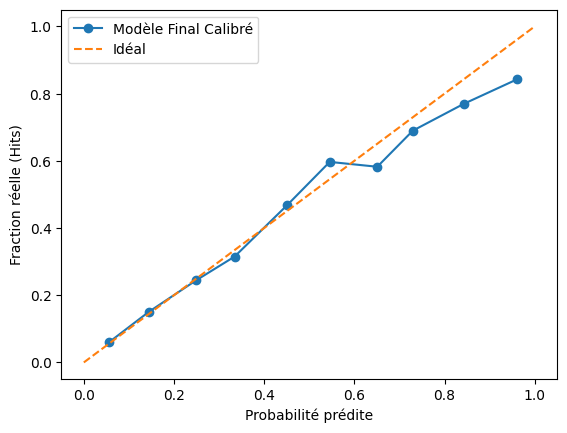

In [13]:
# --- 7. Évaluation FINALE (Sur TEST) ---
# C'est le seul moment où on regarde X_test

print("\n--- Performance Finale (sur Test Set inconnu) ---")
# 1. On prédit les probas sur le Test
test_probs = calibrated_clf.predict_proba(X_test_final)[:, 1]

# 2. On applique le seuil qu'on a trouvé en validation
final_preds = (test_probs >= best_threshold).astype(int)

# 3. Rapport
print(classification_report(y_test, final_preds))
print(f"F2-Score Final : {fbeta_score(y_test, final_preds, beta=2):.3f}")

# 4. Courbe de calibration Finale
prob_true, prob_pred = calibration_curve(y_test, test_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Modèle Final Calibré')
plt.plot([0, 1], [0, 1], linestyle='--', label='Idéal')
plt.xlabel('Probabilité prédite')
plt.ylabel('Fraction réelle (Hits)')
plt.legend()
plt.show()

In [14]:
# --- A. Récupération des noms des colonnes ---

# 1. Vos features numériques (les 79 colonnes)
feats_num = list(X_train_numeric.columns)

# 2. Vos features textuelles (les 2750 colonnes)
# Le preprocessor combine automatiquement les noms des deux vectorizers.
# Il va générer des noms comme "name_tfidf__zombie" ou "short_desc_tfidf__action"
feats_text = list(preprocessor.get_feature_names_out())

# 3. Fusion totale (dans le même ordre que votre hstack)
# Rappel : vous avez fait hstack([X_train_numeric, X_train_tfidf])
all_features = feats_num + feats_text

# --- B. Création du DataFrame d'importance ---

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
})

# --- C. Affichage des Top Facteurs ---

# On trie pour voir les plus influents
top_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

print("=== TOP 20 des facteurs prédisant un SUCCÈS (Hit) ===")
print(top_features)

=== TOP 20 des facteurs prédisant un SUCCÈS (Hit) ===
                                Feature  Importance
3                          initialprice    0.035115
59                categorie_Steam Cloud    0.021672
58         categorie_Steam Achievements    0.016234
61        categorie_Steam Trading Cards    0.014055
68                        num_languages    0.012732
1595             short_desc_tfidf__game    0.010458
5                                   mac    0.008888
77              Lang_Simplified Chinese    0.008441
75                        Lang_Japanese    0.006979
41    categorie_Full Controller Support    0.006937
66                  num_audio_languages    0.006363
0                          required_age    0.006130
72                         Lang_Spanish    0.005987
2                    controller_support    0.005892
2818            short_desc_tfidf__world    0.004880
70                          Lang_French    0.004767
8                          genre_Action    0.004482
12        

In [15]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# scale_pos_weight : Ratio (Nombre de Négatifs / Nombre de Positifs)
# Dans votre cas : ~65000 / ~16000 = ~4
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

xgb_model = XGBClassifier(
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    eval_metric='logloss'    # Métrique d'optimisation
)

# Il accepte directement les matrices sparse (X_train_final)
xgb_model.fit(X_train_final.toarray(), y_train)

# La suite (predict, calibration...) est identique au code Scikit-Learn

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [27]:
y_probs = xgb_model.predict_proba(X_test_final.toarray())[:, 1]

# 2. Votre boucle de test des seuils
print(f"--- Résultats pour Gradient Boosting Classifier ---")

for seuil in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]:
    # On convertit la probabilité en 0 ou 1 selon le seuil
    preds = (y_probs >= seuil).astype(int)
    
    # Calcul des métriques
    # On utilise output_dict=True pour récupérer les valeurs proprement
    report = classification_report(y_test, preds, output_dict=True)
    recall = report['1']['recall']
    precision = report['1']['precision']
    
    # F2-Score (Privilégie le Recall)
    f2score = fbeta_score(y_test, preds, beta=2)
    
    print(f"Seuil {seuil} -> Recall: {recall:.2f} | Precision: {precision:.2f} | F2-Score: {f2score:.2f}")

--- Résultats pour Gradient Boosting Classifier ---
Seuil 0.05 -> Recall: 0.99 | Precision: 0.21 | F2-Score: 0.57
Seuil 0.1 -> Recall: 0.90 | Precision: 0.28 | F2-Score: 0.62
Seuil 0.2 -> Recall: 0.69 | Precision: 0.41 | F2-Score: 0.60
Seuil 0.3 -> Recall: 0.52 | Precision: 0.51 | F2-Score: 0.51
Seuil 0.4 -> Recall: 0.39 | Precision: 0.58 | F2-Score: 0.42
Seuil 0.5 -> Recall: 0.26 | Precision: 0.64 | F2-Score: 0.30
Seuil 0.7 -> Recall: 0.06 | Precision: 0.80 | F2-Score: 0.08
Seuil 0.9 -> Recall: 0.00 | Precision: 1.00 | F2-Score: 0.00


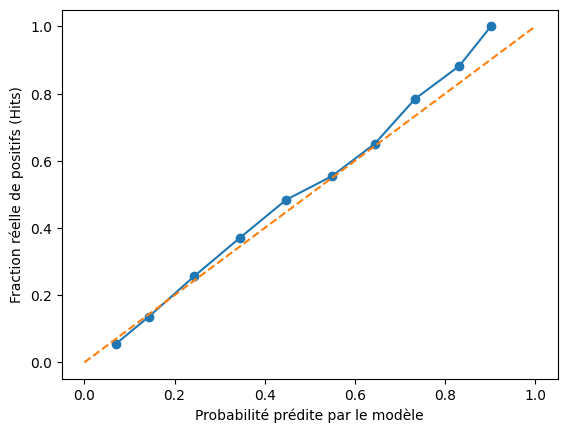

In [17]:
# Prediction
y_probs = xgb_model.predict_proba(X_test_final.toarray())[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Votre Modèle')
plt.plot([0, 1], [0, 1], linestyle='--', label='Parfaitement calibré')
plt.xlabel('Probabilité prédite par le modèle')
plt.ylabel('Fraction réelle de positifs (Hits)')
plt.show()

In [18]:

resultats = pd.DataFrame({ 'appid': ids_test, 'vraie_valeur': y_test, })

y_probs_rf = calibrated_clf.predict_proba(X_test_final)[:, 1]
y_probs_xgb = xgb_model.predict_proba(X_test_final.toarray())[:, 1]

probas_rf = pd.DataFrame({ 'appid': ids_test, 'proba prédite': y_probs_rf, "is_hit": y_test  })
probas_xgb = pd.DataFrame({ 'appid': ids_test, 'proba prédite': y_probs_xgb, "is_hit": y_test })

print(probas_rf.head())
print(probas_xgb.head())

print(len(probas_rf[ probas_rf['proba prédite'] > 0.2 ]), len(probas_rf[ probas_rf['is_hit'] == 1 ]))
print(len(probas_xgb[ probas_xgb['proba prédite'] > 0.2 ]), len(probas_xgb[ probas_xgb['is_hit'] == 1 ]))



         appid  proba prédite  is_hit
35908  1218230       0.026403       0
70610  2695940       0.250923       1
48119  1617270       0.250923       1
18580   726060       0.076043       0
5060    346500       0.483871       0
         appid  proba prédite  is_hit
35908  1218230       0.051004       0
70610  2695940       0.175498       1
48119  1617270       0.458698       1
18580   726060       0.100719       0
5060    346500       0.672805       0
4091 2440
4109 2440


In [19]:
import numpy as np

def simulateur_succes(appid, model, feature_names, X_data, ids_data, **modifs):
    """
    Simule l'impact de changements de caractéristiques sur la probabilité de succès d'un jeu.
    
    Args:
        appid (int/str): L'identifiant du jeu à tester.
        model: Le modèle entraîné (et calibré de préférence).
        feature_names (list): La liste des noms de toutes les colonnes (dans l'ordre).
        X_data (sparse matrix): La matrice des données (ex: X_test_final).
        ids_data (Series/list): La liste des IDs alignée avec X_data (ex: ids_test).
        **modifs: Les changements à appliquer (ex: initialprice=19.99, genre_Action=1).
    """
    
    # 1. Trouver l'index du jeu dans la matrice
    # On convertit en liste pour chercher la position (0, 1, 2...)
    try:
        if hasattr(ids_data, 'tolist'):
            ids_list = ids_data.tolist()
        else:
            ids_list = list(ids_data)
            
        index_jeu = ids_list.index(appid)
    except ValueError:
        print(f"❌ Erreur : L'AppID {appid} est introuvable dans le dataset fourni.")
        return

    # 2. Récupérer et copier les données originales
    # On convertit la ligne sparse en array dense pour pouvoir la modifier facilement
    # .copy() est essentiel pour ne pas modifier le dataset original !
    row_original = X_data[index_jeu]
    row_modifie = row_original.copy()
    
    # 3. Prédiction Initiale
    if model == "xgb":
        proba_base = xgb_model.predict_proba(row_original.toarray())[0, 1]
    else:
        proba_base = calibrated_clf.predict_proba(row_original)[0, 1]

    # 4. Appliquer les modifications
    print(f"--- Simulation pour le jeu {df[df['appid'] == appid]['name'].to_string()} qui a l'appid {appid} ---")
    
    changements_effectues = []
    
    for feature, nouvelle_valeur in modifs.items():
        if feature in feature_names:
            # On trouve l'index de la colonne correspondant au nom
            col_idx = feature_names.index(feature)
            
            # On stocke l'ancienne valeur pour l'affichage
            ancienne_valeur = row_original[0, col_idx]
            
            # On applique la modification
            row_modifie[0, col_idx] = nouvelle_valeur
            
            changements_effectues.append(
                f"   • '{feature}': {ancienne_valeur} -> {nouvelle_valeur}"
            )
        else:
            print(f"⚠️ Attention : La feature '{feature}' n'existe pas dans le modèle. Ignorée.")

    if not changements_effectues:
        print("Aucune modification valide appliquée.")
        return

    # 5. Prédiction Modifiée
    if model == "xgb":
        proba_simulee = xgb_model.predict_proba(row_modifie.toarray())[0, 1]
    else:
        proba_simulee = calibrated_clf.predict_proba(row_modifie)[0, 1]
    #proba_simulee = model.predict_proba(row_modifie)[0, 1]
    
    # 6. Affichage des résultats (Delta)
    diff = (proba_simulee - proba_base) * 100
    
    print("\n".join(changements_effectues))
    print("-" * 40)
    print(f"Probabilité Initiale : {proba_base:.2%}")
    print(f"Probabilité Simulée  : {proba_simulee:.2%}")
    
    if diff > 0:
        print(f"📈 IMPACT : +{diff:.2f} points (% chance de succès)")
    elif diff < 0:
        print(f"📉 IMPACT : {diff:.2f} points (% chance de succès)")
    else:
        print(f"➡️ IMPACT : Aucune changement significatif.")

In [20]:
print( df[df['appid'].isin(ids_test.values)]["name"].to_string() )

0                                           Counter-Strike
6                                                Half-Life
13                                 Half-Life 2: Deathmatch
14                                 Half-Life 2: Lost Coast
17                                                  Portal
41                                        Source Filmmaker
45                                         Quake III Arena
49                                              Final DOOM
54                      Quake II Mission Pack: Ground Zero
58                                  The Ship: Murder Party
65                                             Alpha Prime
70                          Call of Duty: United Offensive
71                       RollerCoaster Tycoon® 3: Platinum
89                         King's Bounty: Armored Princess
99                                         Dynomite Deluxe
100                                Feeding Frenzy 2 Deluxe
109                                         Peggle Extre

In [21]:
import pandas as pd

def afficher_infos_jeu(appid, df):
    # 1. Récupération de la ligne du jeu
    # On utilise .iloc[0] pour obtenir une Series (objet 1D) au lieu d'un DataFrame
    try:
        jeu = df[df["appid"] == appid].iloc[0]
    except IndexError:
        print(f"❌ Jeu avec AppID {appid} introuvable dans le DataFrame.")
        return

    print(f"\n{'='*60}")
    print(f"🎮 FICHE D'IDENTITÉ : {jeu['name']} (ID: {appid})")
    print(f"{'='*60}")

    # --- 2. Infos Générales (Prix, Description, Age...) ---
    # On liste les colonnes qu'on veut voir en priorité
    cols_prios = ['initialprice', 'required_age', 'is_free', 'controller_support', 'short_description']
    
    print("--- ℹ️ Informations Générales ---")
    for col in cols_prios:
        if col in jeu:
            val = jeu[col]
            # Si c'est la description, on la coupe si elle est trop longue
            if col == 'short_description' and isinstance(val, str) and len(val) > 100:
                val = val[:100] + "..."
            print(f"  • {col}: {val}")

    # --- 3. Gestion des One-Hot Encoding (Genres, Catégories, Langues) ---
    # L'idée est de regrouper tout ce qui commence par "genre_", "categorie_", etc.
    
    groupes = {
        "🎭 Genres": "genre_",
        "🏷️ Catégories": "categorie_",
        "🗣️ Langues Audio": "Lang_",
        "💻 OS Supportés": ["windows", "mac", "linux"] # Cas particulier liste
    }

    for titre_groupe, prefixe in groupes.items():
        valeurs_actives = []
        
        # Cas spécial pour les OS (qui n'ont pas de préfixe commun)
        if isinstance(prefixe, list):
            for os_col in prefixe:
                if os_col in jeu and jeu[os_col] == 1:
                    valeurs_actives.append(os_col.capitalize())
        
        # Cas standard (préfixe)
        else:
            for col in df.columns:
                if col.startswith(prefixe) and jeu[col] == 1:
                    # On nettoie le nom (ex: "genre_Action" -> "Action")
                    nom_propre = col.replace(prefixe, "")
                    valeurs_actives.append(nom_propre)
        
        # Affichage du groupe si non vide
        if valeurs_actives:
            print(f"--- {titre_groupe} ---")
            print("  " + ", ".join(valeurs_actives))

    print(f"{'='*60}\n")

In [31]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[350] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    #initialprice=9.99,
    #controller_support=1,
    mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    #Lang_English= 1
)


🎮 FICHE D'IDENTITÉ : Lewis Quest (ID: 3374590)
--- ℹ️ Informations Générales ---
  • initialprice: 1.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: Reclaim the Lewis family heirloom, in this short 2-D Collectathon Platformer. Navigate treacherous l...
--- 🎭 Genres ---
  Action, Adventure, Indie
--- 🏷️ Catégories ---
  Family Sharing, Partial Controller Support, Single-player, Steam Achievements
--- 🗣️ Langues Audio ---
  English
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 79970    Lewis Quest qui a l'appid 3374590 ---
   • 'mac': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 8.53%
Probabilité Simulée  : 11.21%
📈 IMPACT : +2.68 points (% chance de succès)


In [33]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[1] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    #initialprice=9.99,
    #controller_support=1,
    mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    #Lang_English= 1
)


🎮 FICHE D'IDENTITÉ : PANICORE (ID: 2695940)
--- ℹ️ Informations Générales ---
  • initialprice: 4.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: PANICORE is a survival horror game that mixes permadeath, AI monsters and a co-op experience up to 5...
--- 🎭 Genres ---
  Action, Adventure, Indie
--- 🏷️ Catégories ---
  Co-op, Family Sharing, Multi-player, Online Co-op, Single-player, Steam Achievements, Steam Cloud
--- 🗣️ Langues Audio ---
  English, French, German, Spanish, Portuguese, Russian, Japanese, Korean, Simplified Chinese, Polish
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 70610    PANICORE qui a l'appid 2695940 ---
   • 'mac': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 17.55%
Probabilité Simulée  : 40.28%
📈 IMPACT : +22.73 points (% chance de succès)


In [34]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[10] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    #initialprice=9.99,
    #controller_support=1,
    mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    #Lang_English= 1
)


🎮 FICHE D'IDENTITÉ : Cliff Hanger (ID: 515200)
--- ℹ️ Informations Générales ---
  • initialprice: 4.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: The backgrounds up the tempo and players are well equipped with a plethora of attacks! Test your met...
--- 🎭 Genres ---
  Action, Indie
--- 🏷️ Catégories ---
  Family Sharing, Partial Controller Support, Single-player, Steam Trading Cards
--- 🗣️ Langues Audio ---
  Japanese
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 10997    Cliff Hanger qui a l'appid 515200 ---
   • 'mac': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 14.64%
Probabilité Simulée  : 19.65%
📈 IMPACT : +5.01 points (% chance de succès)


In [23]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[10] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    #initialprice=9.99,
    #controller_support=1,
    #mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    Lang_English= 1
)


🎮 FICHE D'IDENTITÉ : Cliff Hanger (ID: 515200)
--- ℹ️ Informations Générales ---
  • initialprice: 4.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: The backgrounds up the tempo and players are well equipped with a plethora of attacks! Test your met...
--- 🎭 Genres ---
  Action, Indie
--- 🏷️ Catégories ---
  Family Sharing, Partial Controller Support, Single-player, Steam Trading Cards
--- 🗣️ Langues Audio ---
  Japanese
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 10997    Cliff Hanger qui a l'appid 515200 ---
   • 'Lang_English': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 14.64%
Probabilité Simulée  : 9.74%
📉 IMPACT : -4.91 points (% chance de succès)


In [56]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[10] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    initialprice=0.0,
    is_free= 1,
    #controller_support=1,
    #mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    #Lang_English= 1
)


🎮 FICHE D'IDENTITÉ : Cliff Hanger (ID: 515200)
--- ℹ️ Informations Générales ---
  • initialprice: 4.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: The backgrounds up the tempo and players are well equipped with a plethora of attacks! Test your met...
--- 🎭 Genres ---
  Action, Indie
--- 🏷️ Catégories ---
  Family Sharing, Partial Controller Support, Single-player, Steam Trading Cards
--- 🗣️ Langues Audio ---
  Japanese
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 10997    Cliff Hanger qui a l'appid 515200 ---
   • 'initialprice': 4.99 -> 0.0
   • 'is_free': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 14.64%
Probabilité Simulée  : 17.49%
📈 IMPACT : +2.84 points (% chance de succès)


In [48]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[10] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    #initialprice=29.99,
    #controller_support=1,
    #mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
    **{'Lang_Simplified Chinese': 1}
)


🎮 FICHE D'IDENTITÉ : Cliff Hanger (ID: 515200)
--- ℹ️ Informations Générales ---
  • initialprice: 4.99
  • required_age: 0
  • is_free: 0
  • controller_support: 0
  • short_description: The backgrounds up the tempo and players are well equipped with a plethora of attacks! Test your met...
--- 🎭 Genres ---
  Action, Indie
--- 🏷️ Catégories ---
  Family Sharing, Partial Controller Support, Single-player, Steam Trading Cards
--- 🗣️ Langues Audio ---
  Japanese
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 10997    Cliff Hanger qui a l'appid 515200 ---
   • 'Lang_Simplified Chinese': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 14.64%
Probabilité Simulée  : 16.58%
📈 IMPACT : +1.94 points (% chance de succès)


In [49]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[550] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    initialprice=29.99,
    #controller_support=1,
    #mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
)


🎮 FICHE D'IDENTITÉ : Viking Trickshot (ID: 1057990)
--- ℹ️ Informations Générales ---
  • initialprice: 0.0
  • required_age: 0
  • is_free: 1
  • controller_support: 0
  • short_description: A throwing physics challenge that's tricky to master, set in a bizarre Viking universe. 2P features ...
--- 🎭 Genres ---
  Action, Casual, Free to Play, Indie, Simulation, Sports
--- 🏷️ Catégories ---
  Multi-player, Online PvP, PvP, Remote Play, Shared/Split Screen, Single-player, Steam Achievements, Steam Cloud
--- 🗣️ Langues Audio ---
  English
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 30353    Viking Trickshot qui a l'appid 1057990 ---
   • 'initialprice': 0.0 -> 29.99
----------------------------------------
Probabilité Initiale : 12.58%
Probabilité Simulée  : 25.04%
📈 IMPACT : +12.45 points (% chance de succès)


In [55]:
# Exemple concret d'appel
un_vrai_id = ids_test.iloc[550] # Juste pour l'exemple, on prend le premier
afficher_infos_jeu(un_vrai_id, df)
# Correctif immédiat sans tout relancer
X_test_final = X_test_final.tocsr()

simulateur_succes(
    appid=un_vrai_id,
    model="xgb",           # Votre modèle (ou calibrated_model)
    feature_names=all_features,# La liste créée lors de l'analyse d'importance
    X_data=X_test_final,       # Vos données de test
    ids_data=ids_test,         # Vos IDs de test
    
    # Vos modifications (kwargs) :
    Lang_French= 1,
    #controller_support=1,
    #mac=1,
    #genre_Indie= 1,
    #genre_Action=1,             # On enlève le genre Action par exemple
)


🎮 FICHE D'IDENTITÉ : Viking Trickshot (ID: 1057990)
--- ℹ️ Informations Générales ---
  • initialprice: 0.0
  • required_age: 0
  • is_free: 1
  • controller_support: 0
  • short_description: A throwing physics challenge that's tricky to master, set in a bizarre Viking universe. 2P features ...
--- 🎭 Genres ---
  Action, Casual, Free to Play, Indie, Simulation, Sports
--- 🏷️ Catégories ---
  Multi-player, Online PvP, PvP, Remote Play, Shared/Split Screen, Single-player, Steam Achievements, Steam Cloud
--- 🗣️ Langues Audio ---
  English
--- 💻 OS Supportés ---
  Windows

--- Simulation pour le jeu 30353    Viking Trickshot qui a l'appid 1057990 ---
   • 'Lang_French': 0.0 -> 1
----------------------------------------
Probabilité Initiale : 12.58%
Probabilité Simulée  : 12.58%
➡️ IMPACT : Aucune changement significatif.


c:\Users\Chems\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
